In [1]:
import boto3
import botocore
import sys
import matplotlib.pyplot as plt
import pandas as pd
import io
from io import StringIO
from datetime import datetime
import sagemaker
from sagemaker import RandomCutForest
from sagemaker.predictor import csv_serializer, json_deserializer


#bucket = 'ads-bucket-senichol'   # <--- specify a bucket you have access to
#prefix = 'kaggle-crypto-data/RCF'

bucket = 'sagemaker-davidrob'
prefix = 'group-project/bitcoin'

execution_role = sagemaker.get_execution_role()


# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://sagemaker-davidrob/group-project/bitcoin


In [2]:
# Step 1: get the bitcoin minute-by-minute data from kaggle (one way or another)
# https://www.kaggle.com/mczielinski/bitcoin-historical-data
# https://www.kaggle.com/mczielinski/bitcoin-historical-data#bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv

#!pip install kaggle
#!kaggle datasets download -d mczielinski/bitcoin-historical-data
#!mkdir bitcoin-historical-data
#!mv bitcoin-historical-data.zip /bitcoin-historical-data
#!unzip -a /bitcoin-historical-data/bitcoin-historical-data.zip
#df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv', encoding="ISO-8859-1", low_memory=False)

# Either run the lines above this comment or do something like the lines below.

# I saved and unzipped the file to my instance via the above lines, but ran into some difficulty reading it. 
# I tried messing with the path a bit, and then gave up and just read the data from my own S3 bucket

s3 = boto3.client('s3')
raw_data = s3.get_object(Bucket=bucket, Key=f'group-project/bitcoin/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv')
df = pd.read_csv(io.BytesIO(raw_data['Body'].read()), encoding="ISO-8859-1", low_memory=False)

In [3]:
# Step 2: Add day and hour data elements to the dataframe so we can group by days and hours in later analysis


# create various date formats for grouping later on
df['Time'] = pd.to_datetime(df['Timestamp'], unit = 's', infer_datetime_format = 'True')
#df['Date'] = df['Time'].values.astype('datetime64[D]')
#df['Hour'] = df['Time'].values.astype('datetime64[h]')
df['Minute'] = df['Time'].values.astype('datetime64[m]')

#df['Price15MinuteRollMean'] = df['Weighted_Price'].rolling(15).mean()
#df['Price60MinuteRollMean'] = df['Weighted_Price'].rolling(60).mean()
#df['Price120MinuteRollMean'] = df['Weighted_Price'].rolling(120).mean()
df['Price480MinuteRollMean'] = df['Weighted_Price'].rolling(480).mean()
df['PriceMinus480MinuteRollMean'] = df['Weighted_Price']-df['Weighted_Price'].rolling(480).mean()
df['PriceIntraMinuteDelta'] =  df['High'] - df['Low']

#df['Volume15MinuteRollMean'] = df['Volume_(BTC)'].rolling(15).mean()
#df['Volume60MinuteRollMean'] = df['Volume_(BTC)'].rolling(60).mean()
#df['Volume120MinuteRollMean'] = df['Volume_(BTC)'].rolling(120).mean()
df['Volume480MinuteRollMean'] = df['Volume_(BTC)'].rolling(480).mean()
df['Volume120Minus480RollMean'] = df['Volume_(BTC)'].rolling(120).mean()-df['Volume_(BTC)'].rolling(480).mean()

df.drop(columns=['Time', 'Timestamp','Open','Close','High'])

#drop the first 480 records because they won't have data to calculate the largest-window moving average
df.drop(df.index[:480], inplace=True)

# reality check - make sure the dataframe looks right so far.
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Time,Minute,Price480MinuteRollMean,PriceMinus480MinuteRollMean,PriceIntraMinuteDelta,Volume480MinuteRollMean,Volume120Minus480RollMean
480,1325346720,4.39,4.39,4.39,4.39,48.0,210.72,4.39,2011-12-31 15:52:00,2011-12-31 15:52:00,4.39,-3.996803e-14,0.0,0.752733,0.891458
481,1325346780,4.39,4.39,4.39,4.39,48.0,210.72,4.39,2011-12-31 15:53:00,2011-12-31 15:53:00,4.39,-3.996803e-14,0.0,0.851784,1.188610
482,1325346840,4.39,4.39,4.39,4.39,48.0,210.72,4.39,2011-12-31 15:54:00,2011-12-31 15:54:00,4.39,-3.996803e-14,0.0,0.950835,1.485763
483,1325346900,4.39,4.39,4.39,4.39,48.0,210.72,4.39,2011-12-31 15:55:00,2011-12-31 15:55:00,4.39,-3.996803e-14,0.0,1.049886,1.782916
484,1325346960,4.39,4.39,4.39,4.39,48.0,210.72,4.39,2011-12-31 15:56:00,2011-12-31 15:56:00,4.39,-3.996803e-14,0.0,1.148937,2.080068


In [4]:
#Step 3:  Make the timestamp the index of the dataframe, and drop several fields (minute, high, low, close)

df_minute_data = df[['Minute','Open', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price',
                           #'Price15MinuteRollMean','Price60MinuteRollMean','Price120MinuteRollMean',
                           'Price480MinuteRollMean',
                           'PriceMinus480MinuteRollMean',
                           'PriceIntraMinuteDelta',
                           #'Volume15MinuteRollMean','Volume60MinuteRollMean','Volume120MinuteRollMean',
                           'Volume480MinuteRollMean',
                           'Volume120Minus480RollMean']]
df_minute_data = df_minute_data.set_index(pd.DatetimeIndex(df_minute_data['Minute']).values)
df_minute_data = df_minute_data.drop(columns = ['Minute'])

df_minute_data.head()

,Open,Volume_(BTC),Volume_(Currency),Weighted_Price,Price480MinuteRollMean,PriceMinus480MinuteRollMean,PriceIntraMinuteDelta,Volume480MinuteRollMean,Volume120Minus480RollMean
2011-12-31 15:52:00,4.39,48.0,210.72,4.39,4.39,-3.996803e-14,0.0,0.752733,0.891458
2011-12-31 15:53:00,4.39,48.0,210.72,4.39,4.39,-3.996803e-14,0.0,0.851784,1.188610
2011-12-31 15:54:00,4.39,48.0,210.72,4.39,4.39,-3.996803e-14,0.0,0.950835,1.485763
2011-12-31 15:55:00,4.39,48.0,210.72,4.39,4.39,-3.996803e-14,0.0,1.049886,1.782916
2011-12-31 15:56:00,4.39,48.0,210.72,4.39,4.39,-3.996803e-14,0.0,1.148937,2.080068


The following code block builds a dictionary (dict_anomaly_windows) containing subset dataframes that wrap around each of the anomalous days found in the first phase of our analysis.

For 28 days before and 7 days after an anomalous event, we grab the minute-level data 

In [5]:
# Step 4: for each of the top anomalies identified in the first round of analysis, build a date range around the date of the anomaly.
# We are taking a closer look at the minute-level data 31 days before and 7 days after each of the top anomalies.

from datetime import timedelta 

# ideally, this hard-coded list will be replaced by a reference to the S3 object generated by Martin's notebook
dates = ["4/20/2018","3/4/2018","2/22/2018","2/6/2018","1/14/2018","12/28/2017","12/24/2017","12/22/2017","12/20/2017","12/19/2017"]
df_anomaly_windows = pd.DataFrame({'anomaly': [pd.to_datetime(d) for d in dates],
                                'begin': [pd.to_datetime(d) - timedelta(days=31) for d in dates],
                                'end': [pd.to_datetime(d) + timedelta(days=7) for d in dates]},
                                 index = [pd.to_datetime(d) for d in dates])

#print(df_month_ranges)

dict_anomaly_windows = {}
for index, row in df_anomaly_windows.iterrows():
    #print( row['begin'], row['end'])
    data = df_minute_data.loc[row['begin']:row['end']]
    dict_anomaly_windows.update({index: data})
    #print("#################################################################################")
    #print(dict_anomaly_windows[index].head())

#for key, value in dict_anomaly_windows.items():
#    print(key)

<Figure size 720x2880 with 0 Axes>

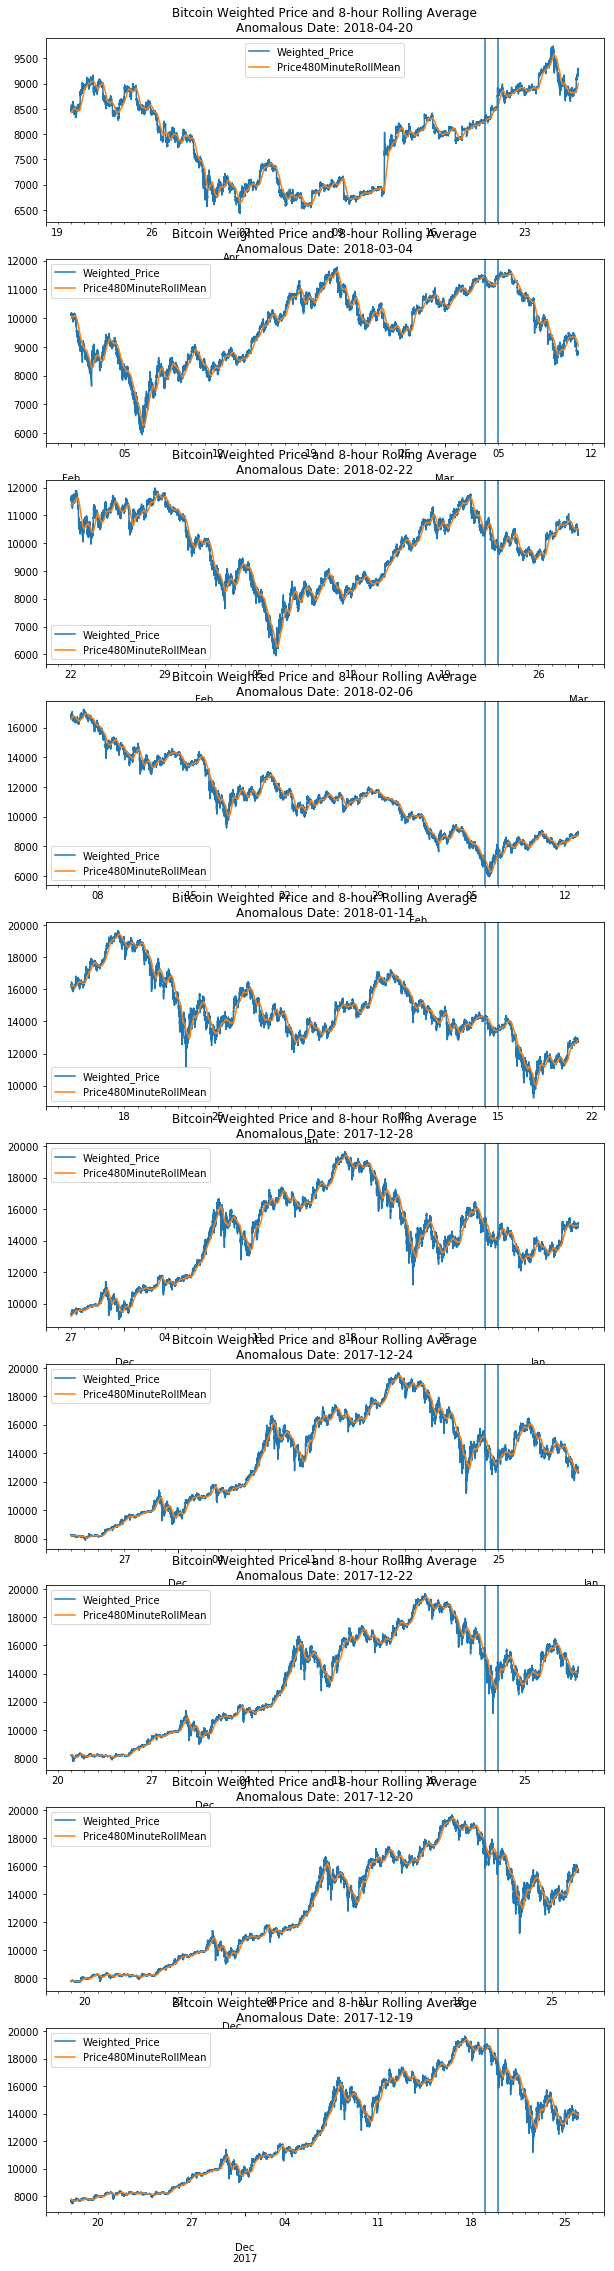

In [107]:
# Step 5: Plotting price vs 8-hour rolling average of price

# http://jonathansoma.com/lede/data-studio/classes/small-multiples/long-explanation-of-using-plt-subplots-to-create-small-multiples/
plt.figure(figsize=(10,40), facecolor='white')

sz = len(dict_anomaly_windows)
plot_number = 0

fig, axes = plt.subplots(nrows=sz, ncols=1, sharex=False, sharey=False, figsize=(10,40))

for key, value in dict_anomaly_windows.items():
    ax = axes[plot_number]
    value['Weighted_Price'].plot(ax = ax, legend=True)
    value['Price480MinuteRollMean'].plot(ax = ax, legend=True)
    ax.axvline(x=key)
    ax.axvline(x=key + timedelta(days=1))
    #value['PriceMinus480MinuteRollMean'].plot(x='Date', y='Price', legend=True, ax = ax)
    ax.set_title("Bitcoin Weighted Price and 8-hour Rolling Average\nAnomalous Date: " + key.strftime("%Y-%m-%d"))
    plot_number = plot_number + 1

plt.savefig('price_and_rolling_average.png', bbox_inches='tight')


<Figure size 720x2880 with 0 Axes>

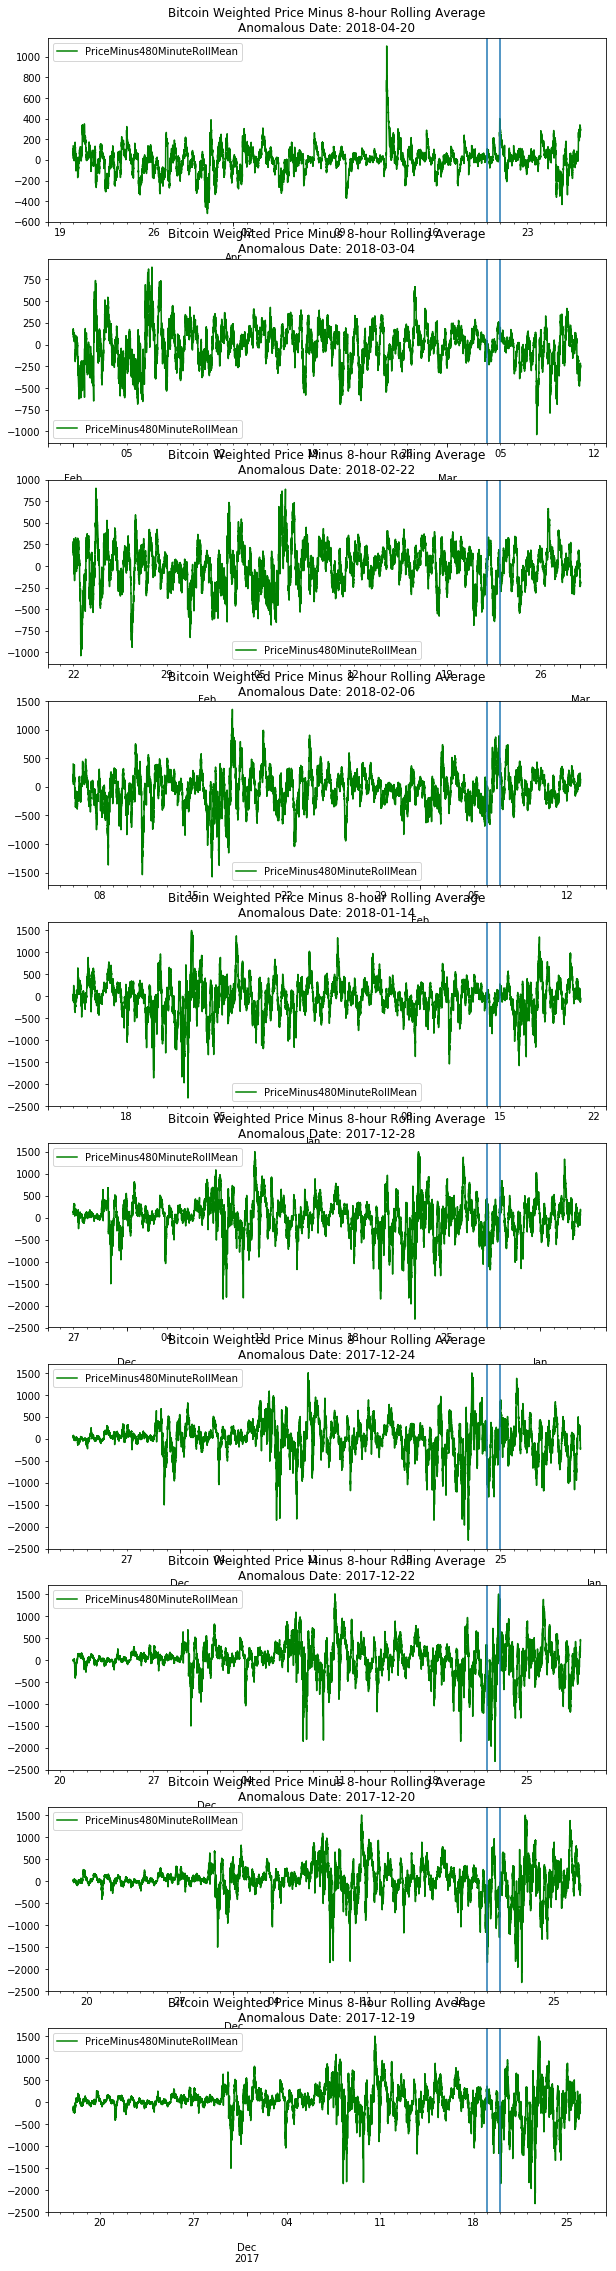

In [108]:
# Step 6: Plotting difference of price minus 8-hour rolling average of price

plt.figure(figsize=(10,40), facecolor='white')

sz = len(dict_anomaly_windows)
plot_number = 0

fig, axes = plt.subplots(nrows=sz, ncols=1, sharex=False, sharey=False, figsize=(10,40))

for key, value in dict_anomaly_windows.items():
    ax = axes[plot_number]
    #value['Weighted_Price'].plot(ax = ax, legend=True)
    value['PriceMinus480MinuteRollMean'].plot(ax = ax, legend=True, color='g')
    ax.axvline(x=key)
    ax.axvline(x=key + timedelta(days=1))
    #value['PriceMinus480MinuteRollMean'].plot(x='Date', y='Price', legend=True, ax = ax)
    ax.set_title("Bitcoin Weighted Price Minus 8-hour Rolling Average\nAnomalous Date: " + key.strftime("%Y-%m-%d"))
    plot_number = plot_number + 1
    
plt.savefig('price_minus_rolling_average.png', bbox_inches='tight')

<Figure size 720x2880 with 0 Axes>

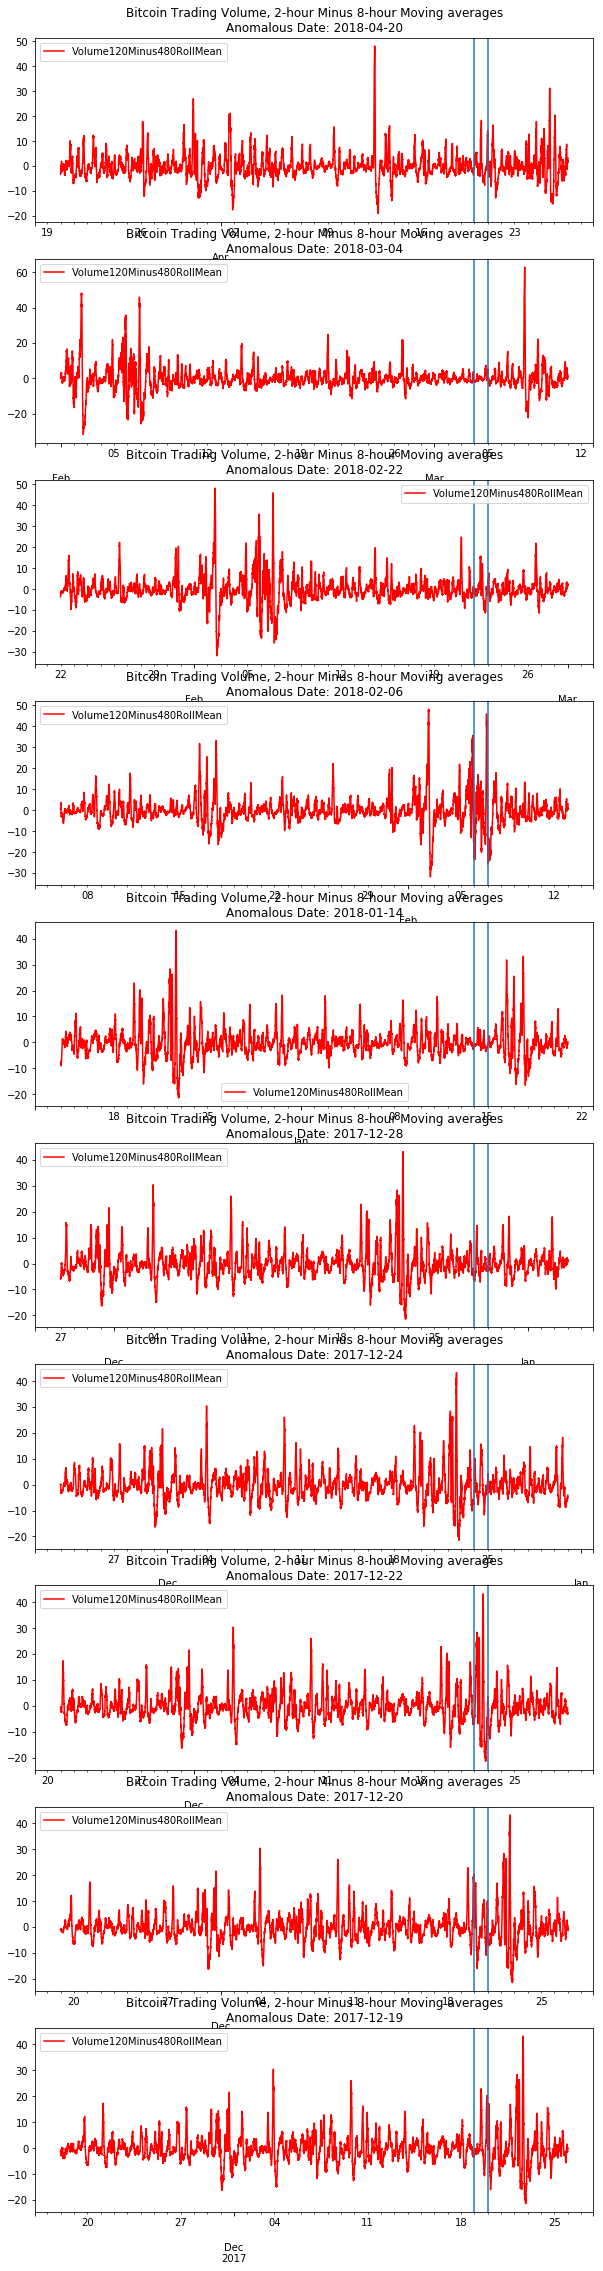

In [109]:
# Step 7: Plot the moving averages of price
plt.figure(figsize=(10,40), facecolor='white')

sz = len(dict_anomaly_windows)
plot_number = 0

fig, axes = plt.subplots(nrows=sz, ncols=1, sharex=False, sharey=False, figsize=(10,40))

for key, value in dict_anomaly_windows.items():
    ax = axes[plot_number]
    #value['Volume120Minus480RollMean'].plot(ax = ax, legend=True)
    value['Volume120Minus480RollMean'].plot(ax = ax, legend=True, color='r')
    ax.axvline(x=key)
    ax.axvline(x=key + timedelta(days=1))
    ax.set_title("Bitcoin Trading Volume, 2-hour Minus 8-hour Moving averages\nAnomalous Date: " + key.strftime("%Y-%m-%d"))
    plot_number = plot_number + 1
    
plt.savefig('volume_rolling_averages_differences.png', bbox_inches='tight')

<Figure size 720x2880 with 0 Axes>

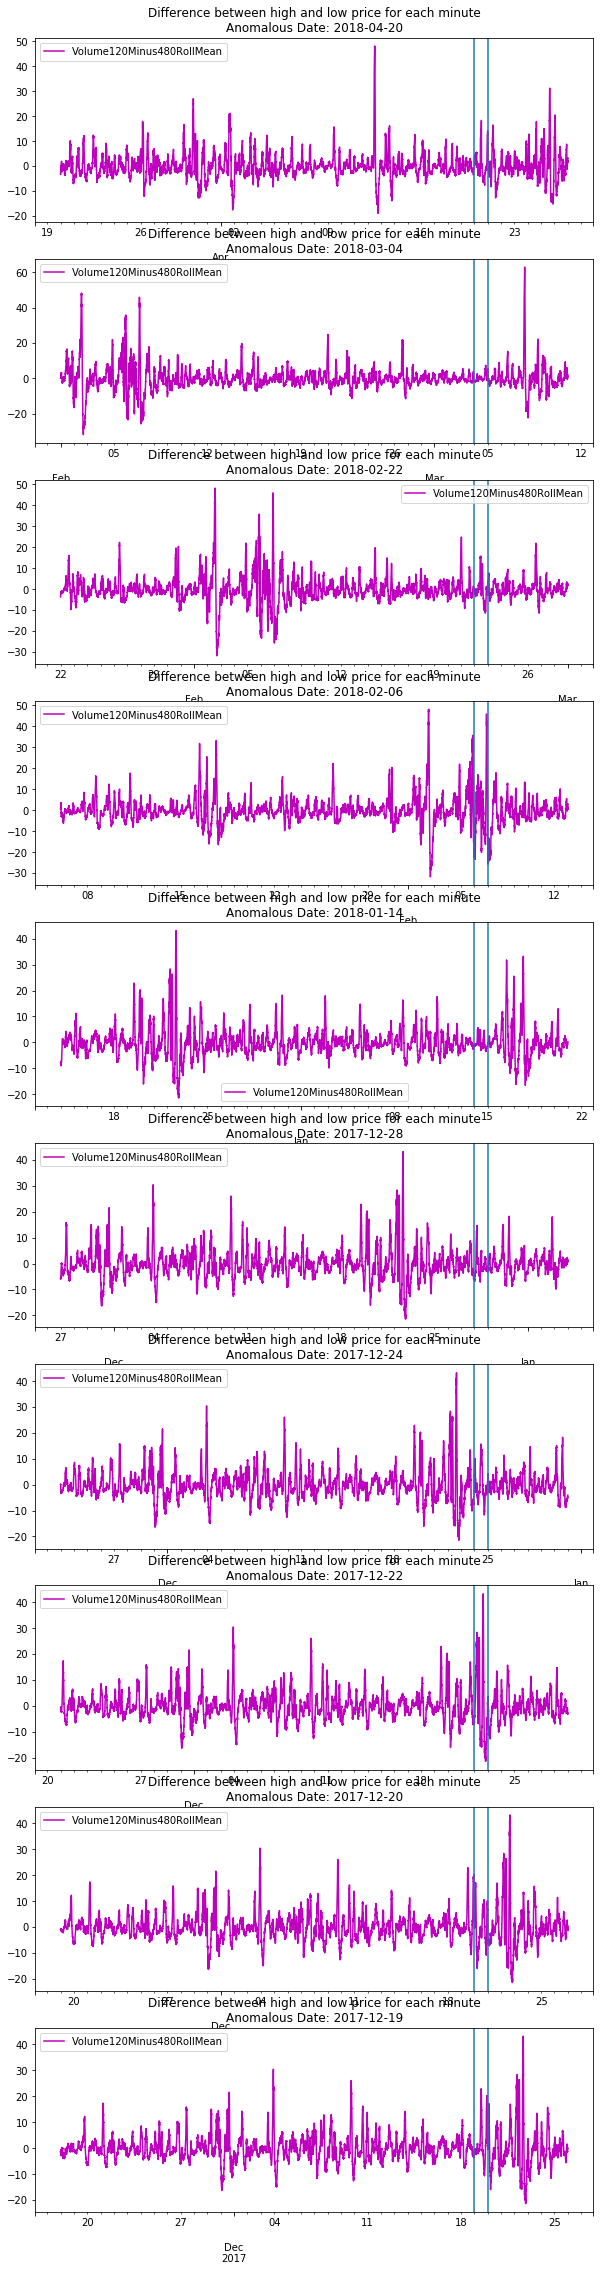

In [110]:
# Step 8: Plot the intra-minute delta price
plt.figure(figsize=(10,40), facecolor='white')

sz = len(dict_anomaly_windows)
plot_number = 0

fig, axes = plt.subplots(nrows=sz, ncols=1, sharex=False, sharey=False, figsize=(10,40))

for key, value in dict_anomaly_windows.items():
    ax = axes[plot_number]
    #value['Volume120Minus480RollMean'].plot(ax = ax, legend=True)
    value['Volume120Minus480RollMean'].plot(ax = ax, legend=True, color='m')
    ax.axvline(x=key)
    ax.axvline(x=key + timedelta(days=1))
    ax.set_title("Difference between high and low price for each minute\nAnomalous Date: " + key.strftime("%Y-%m-%d"))
    plot_number = plot_number + 1

plt.savefig('intra-minute-price-deltas.png', bbox_inches='tight')

In the following section, change what is passed into the fit() method with the subset(s) from the above section.

In [9]:
# Step 9: build the models

session = sagemaker.Session()
# specify general training job information
rcf_minute = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.c5.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=500,
                      num_trees=200)

# automatically upload the training data to S3 and run the training job
for key, value in dict_anomaly_windows.items():
    rcf_minute.fit(rcf_minute.record_set(value.values), job_name="RCF-minute-data-" + key.strftime("%Y-%m-%d"))

In [17]:
# Step 6:  spin up endpoint instance(s) for generating anamaly scores. 

rcf_inference = rcf_minute.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.xlarge',
)

ConnectionClosedError: Connection was closed before we received a valid response from endpoint URL: "https://runtime.sagemaker.us-east-1.amazonaws.com/endpoints/RCF-minute-data-gamma-2018-04-20/invocations".

In [12]:
# Step 8: Here we take the selected data and reformat it according to the format we just specified in step 7.
for key, value in dict_anomaly_windows.items():
    df_scored_numpy = df_scored.as_matrix()

# reality check - what do the first few items in this array matrix like?
print(df_scored_numpy[:6])

[[ 1.38800000e+04  4.96799665e+00  6.90307189e+04  1.38950816e+04
  -6.02809825e+01  6.53700000e+01 -3.79136742e+00]
 [ 1.38410100e+04  1.66584956e+00  2.30640824e+04  1.38452372e+04
  -1.11045052e+02  4.94200000e+01 -3.80714913e+00]
 [ 1.38466400e+04  2.69345780e-01  3.73969084e+03  1.38843491e+04
  -7.28845065e+01  4.37100000e+01 -4.04036930e+00]
 [ 1.38475100e+04  1.15527415e+00  1.59862795e+04  1.38376501e+04
  -1.20390936e+02  5.17300000e+01 -4.04472771e+00]
 [ 1.38231900e+04  6.46690840e-01  8.93046577e+03  1.38094824e+04
  -1.49232971e+02  2.35500000e+01 -3.97161707e+00]
 [ 1.38261000e+04  3.80304093e+01  5.24066713e+05  1.37802018e+04
  -1.79001898e+02  9.16500000e+01 -3.62724450e+00]]


In [13]:
# Step 9: generate anomaly scores using the endpoints.

results = rcf_inference.predict(df_scored_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to selected dataframe and print first few values
df_scored['score'] = pd.Series(scores, index=df_scored.index)
print(df_scored.head())


# This section is useful when scoring all 3.4 million records (Would be use instead of the few lines above.)
# Let's try breaking it up into ~340 chunks of 10,000 records 
#df_minute_inferences_numpy = dict_monthly_ranges_of_minutes['2015-03'].as_matrix()

#from collections import defaultdict
#results = defaultdict(list)

# this function splits the dataset into subsets of n records each
#def get_every_n(a, n=2):
#    counter = 0
#    print("Starting " + str((a.shape[0] // n) + 1) + " inference batches.")
#    for i in range((a.shape[0] // n) + 1):
#        if (counter == 10):
#            print(i)
#            counter = 0
#        yield a[n*i:n*(i+1)]
#        counter += 1

#for subset in get_every_n(df_minute_inferences_numpy,10000):
#    subset_results = rcf_inference.predict(subset)
#    for score in subset_results['scores']:
#        results['scores'].append(score)

# reality check - how many scores did we generate?
print("Completed " + str(len(results['scores'])))

#scores = [datum['score'] for datum in results['scores']]

# add scores to minute-level data frame and print first few values
#df_minute_inferences['score'] = pd.Series(scores, index=dict_monthly_ranges_of_minutes['2015-03'].index)
#df_minute_inferences.head()

                         Open  Volume_(BTC)  Volume_(Currency)  \
2018-01-01 00:00:00  13880.00      4.967997       69030.718890   
2018-01-01 00:01:00  13841.01      1.665850       23064.082359   
2018-01-01 00:02:00  13846.64      0.269346        3739.690844   
2018-01-01 00:03:00  13847.51      1.155274       15986.279494   
2018-01-01 00:04:00  13823.19      0.646691        8930.465767   

                     Weighted_Price  PriceMinus480MinuteRollMean  \
2018-01-01 00:00:00    13895.081610                   -60.280982   
2018-01-01 00:01:00    13845.237237                  -111.045052   
2018-01-01 00:02:00    13884.349123                   -72.884507   
2018-01-01 00:03:00    13837.650132                  -120.390936   
2018-01-01 00:04:00    13809.482390                  -149.232971   

                     PriceIntraMinuteDelta  Volume120Minus480RollMean  \
2018-01-01 00:00:00                  65.37                  -3.791367   
2018-01-01 00:01:00                  49.42      

In [14]:
# Step 10: Delete the endpoint(s). They're expensive.

sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2018-10-06-13-48-46-568


In [15]:
# Step 11: save the inferences to a csv on S3. This way we don't have to redo steps 16-21, which take 30 to 60 minutes.

csv_buffer = StringIO()
df_scored.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'minute_level_inferences_2015_03.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '2A75F4927562283F',
  'HostId': '2wyAwQGQ4epwmm+ImoMqS5qofJelfsE5/Vu/clSg4OPReLpZOy5I4r/HkAFF2ID1LVRrHbRDEL0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '2wyAwQGQ4epwmm+ImoMqS5qofJelfsE5/Vu/clSg4OPReLpZOy5I4r/HkAFF2ID1LVRrHbRDEL0=',
   'x-amz-request-id': '2A75F4927562283F',
   'date': 'Sat, 06 Oct 2018 14:11:40 GMT',
   'etag': '"7577e780eb3aadaa51460b1394b2df7b"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"7577e780eb3aadaa51460b1394b2df7b"'}

In [16]:
# Step 12: Optional if you want to load a saved copy of the minute-level inferences instead of regenerating everything in 16-21
# This just reloads the data we just saved in step 11.
raw_data = s3.get_object(Bucket=bucket, Key=f'minute_level_inferences_2015_03.csv')
df_scored = pd.read_csv(io.BytesIO(raw_data['Body'].read()), encoding="ISO-8859-1", low_memory=False)

df_scored = df_scored.set_index(pd.DatetimeIndex(df_scored['Unnamed: 0']).values)
df_scored = df_scored.drop(columns = ['Unnamed: 0'])


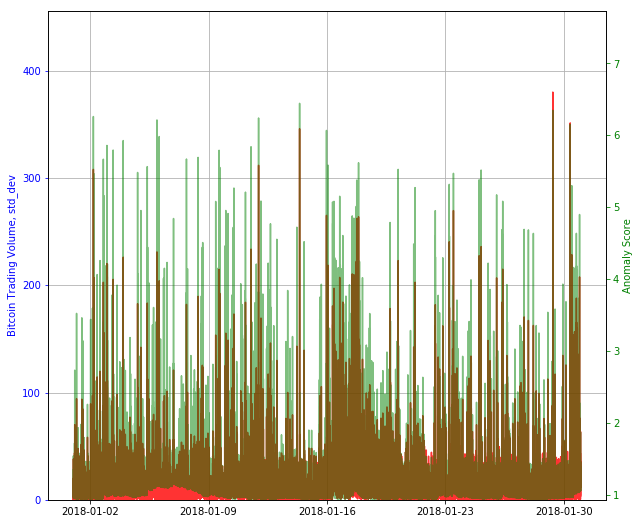

In [17]:
# Pick back up here after the marathon endpoint scoring session...

# Step 13: Plot the anomaly scores along with some features from the minute-level inferences

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#https://matplotlib.org/2.0.2/api/colors_api.html

ax1.plot(df_scored['Volume_(BTC)'], color='r', alpha=0.8)
ax1.plot(df_scored['Open'], color='b', alpha=1)
ax2.plot(df_scored['score'], color='g', alpha=.5)

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Bitcoin Trading Volume, std_dev', color='b')
ax2.set_ylabel('Anomaly Score', color='g')

ax1.tick_params('y', colors='b')
ax2.tick_params('y', colors='g')

ax1.set_ylim(0, 1.2*max(df_scored['Volume_(BTC)']))
ax2.set_ylim(min(df_scored['score']), 1.2*max(df_scored['score']))
fig.set_figwidth(10)

In [18]:
# Step 14: Anomalies are defined as scores greater than 3 standard deviations fronm the mean of score.

score_mean = df_scored['score'].mean()
score_std = df_scored['score'].std()
score_cutoff = score_mean + 3*score_std

anomalies = df_scored[df_scored['score'] > score_cutoff]
print("At a 3 sd threshhold, there are " + str(len(anomalies.score)) + " anomalies.")
anomalies.head()

At a 3 sd threshhold, there are 816 anomalies.


,Open,Volume_(BTC),Volume_(Currency),Weighted_Price,PriceMinus480MinuteRollMean,PriceIntraMinuteDelta,Volume120Minus480RollMean,score
2018-01-01 01:58:00,13330.01,69.986422,9.321616e+05,13319.177629,-563.782620,28.06,0.927039,2.737257
2018-01-01 03:27:00,13595.99,60.921633,8.295004e+05,13615.859902,-174.364650,106.98,1.242741,2.459765
2018-01-01 04:34:00,13565.50,94.230516,1.279566e+06,13579.107688,-146.235745,78.55,0.216293,3.526423
2018-01-01 12:03:00,13362.98,93.758844,1.255378e+06,13389.435009,-176.423816,52.41,1.870677,3.464678
2018-01-01 13:48:00,13094.87,84.597576,1.104655e+06,13057.763143,-442.381758,63.19,3.411125,3.143458


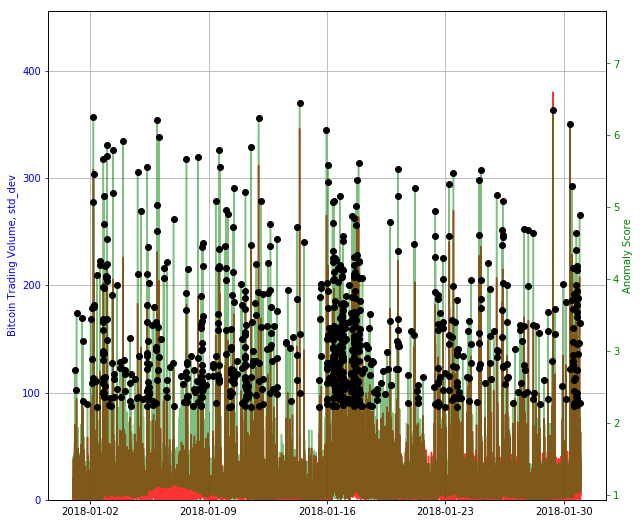

In [19]:
# Step 15: Add the anomalies to the plot.

ax2.plot(anomalies.index, anomalies.score, 'ko')
fig
